In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
import time
sys.path.insert(1, '/home/nicolas/code/src')
sys.path.insert(1, '/home/nicolas/code/data')

from RBM import RBM
from scipy.integrate import simps
from scipy import stats


device = torch.device("cuda")
dtype = torch.float
torch.set_num_threads(4)

In [2]:
def TMCSample(v, w_hat, N, V,it_mcmc=100,it_mean=50, ß=1):
    vtab = torch.zeros(v.shape, device = device)
    v_curr = v
    V = V
    norm = 1/(v_curr.shape[0]**0.5)
    w_curr = (torch.mv(v_curr.T, V)*norm)
    
    index = torch.randperm(v_curr.shape[0])
    for t in range(it_mcmc):
        print(t)
        h_curr, _ = myRBM.SampleHiddens01(v_curr)
        h_i = (torch.mm(myRBM.W.T, h_curr)+myRBM.vbias.reshape(v.shape[0],1)) # Nv x Ns
        w_next = w_curr.clone()
        
        v_next = torch.clone(v_curr)
        index = torch.randperm(v_curr.shape[0])
    
        for idx in range(v_curr.shape[0]):
            i = idx
            v_next[i,:] = 1-v_curr[i,:]
            w_next += ((2*v_next[i,:]-1)*V[i]*norm)

            # On calcul -DeltaE
            ΔE = ß*((2*v_next[i,:]-1)*h_i[i,:])-(N/2)*((w_hat-w_next)**2-(w_hat-w_curr)**2)

            tir = torch.rand(v_curr.shape[1],1, device = torch.device("cuda")).squeeze()
            prob = torch.exp(ΔE).squeeze()
            v_curr[i,:] = torch.where(tir<prob, v_next[i,:], v_curr[i,:])
            v_next[i,:] = torch.where(tir<prob, v_next[i,:], 1-v_next[i,:])
            w_curr = torch.where(tir<prob, w_next, w_curr)
            w_next = torch.where(tir<prob, w_next, w_curr)
        if (t>= (it_mcmc-it_mean)):
            vtab += v_curr
    vtab = vtab*(1/it_mean)    
    return v_curr, h_curr, vtab

In [3]:
W = np.genfromtxt('../data/C1d5c/rbm_W.dat').T
vbias = np.genfromtxt('../data/C1d5c/rbm_vis.dat')
hbias = -np.genfromtxt('../data/C1d5c/rbm_hid.dat')
data = np.genfromtxt('../data/C1d5c/data_5.dat')
data = (data+1)/2

lr = 0.01
l2 = 0
NGibbs = 10
annSteps = 0
mb_s = 500
num_pcd = 500
Nh = W.shape[0]
Nv = W.shape[1]

ep_max = 100

In [4]:
myRBM = RBM(num_visible=Nv,
				num_hidden=Nh,
				device=device,
				lr=lr,
				#regL2=l2,
				gibbs_steps=NGibbs,
				#anneal_steps=annSteps,
				UpdCentered=True,
				mb_s=mb_s,
				num_pcd=num_pcd)

myRBM.W = torch.tensor(4*W).float().cuda()
myRBM.vbias = torch.tensor(2*vbias - 2*W.sum(0)).float().to(device)
myRBM.hbias = torch.tensor(2*hbias - 2*W.sum(1)).float().to(device)
_, _, V = torch.svd(torch.tensor(4*W).float().cuda())


In [5]:
#start_points = torch.bernoulli(torch.rand(myRBM.Nv, 1000, device = device))
#arrival,_,_,_ = myRBM.Sampling(start_points, it_mcmc = 1000)
#proj_gen = torch.mm(arrival.T, V).cpu()/myRBM.Nv**0.5

In [6]:
nb_chain = 15 # Nb de chaines pour chaque w_hat
it_mcmc = 200 # Nb it_mcmc pour chaque chaine
it_mean = 150 # Nb it considérée pour la moyenne temporelle de chaque chaine
N = 20000 # Contrainte
nb_point = 10000 # Nb de points de discrétisation pour w_hat
xmin = -0.0 
xmax = 1.0

In [7]:
start = torch.bernoulli(torch.rand(myRBM.Nv, nb_chain*nb_point, device = device))
V0 = V[:,0]
# w_hat = torch.dot(start.T, V)[0:,]
w_hat_b = torch.linspace(xmin, xmax, steps =nb_point, device = device)
w_hat = torch.zeros(nb_chain*nb_point, device = device)
for i in range(nb_point):
    for j in range(nb_chain):
        w_hat[i*nb_chain+j] = w_hat_b[i]
tmpv, tmph, vtab = TMCSample(start, w_hat, N, V0, it_mcmc = it_mcmc, it_mean=it_mean)

y = np.array(torch.mm(vtab.T, V0.unsqueeze(1)).cpu().squeeze())/myRBM.Nv**0.5
newy = np.array([np.mean(y[i*nb_chain:i*nb_chain+nb_chain]) for i in range(nb_point)])
w_hat = w_hat.cpu().numpy()
w_hat_b = w_hat_b.cpu().numpy()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [8]:
res=np.zeros(len(w_hat_b)-1)
for i in range(1,len(w_hat_b)):
    res[i-1] = simps(newy[:i]-w_hat_b[:i], w_hat_b[:i])
const = simps(np.exp(N*res), w_hat_b[:-1])
p_m = np.exp(N*res)/const
print(simps(p_m, w_hat_b[:-1]))
potential = res + (1/N)*np.log(const)

0.9999999999999999


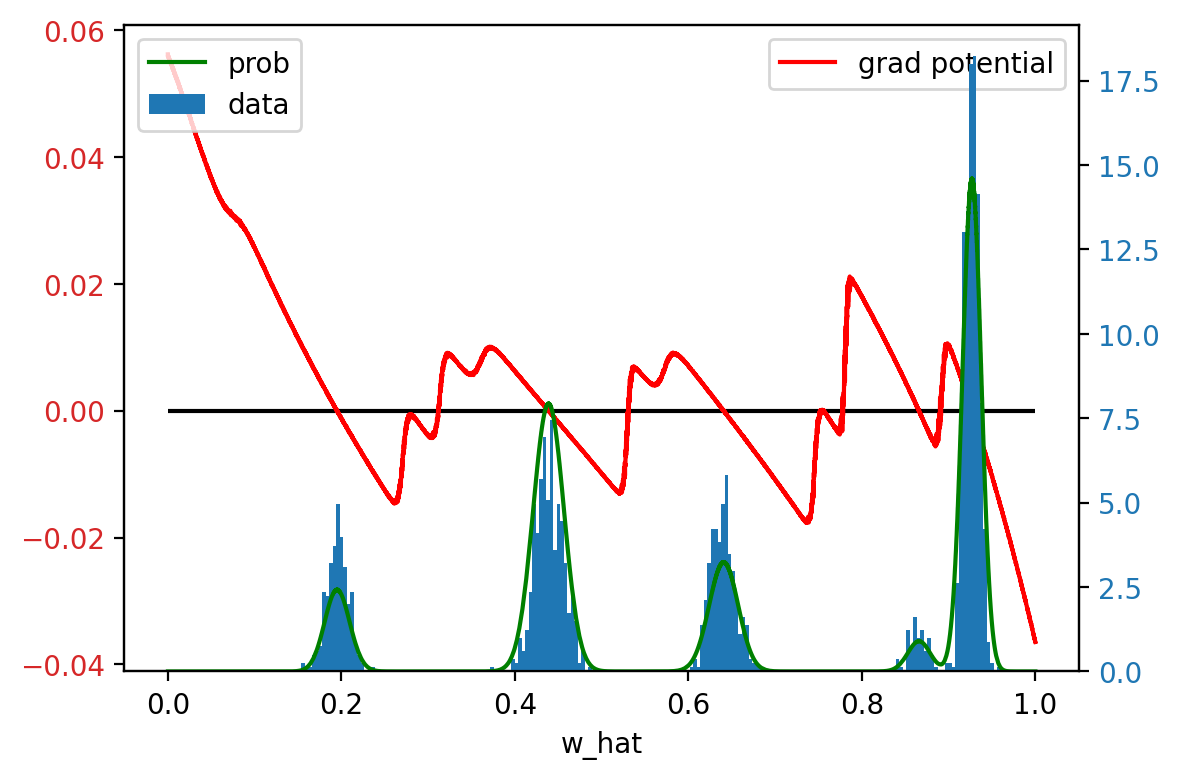

In [9]:
proj_data =torch.mm(torch.tensor(data, device = device, dtype = dtype), V).cpu()/myRBM.Nv**0.5
fig, ax1 = plt.subplots(dpi = 200)

color = 'tab:red'
ax1.set_xlabel("w_hat")
ax1.plot(w_hat_b,newy-w_hat_b,color='red', label = "grad potential")
ax1.hlines(0,0,1, color = 'black')
#ax1.scatter(proj_gen[:,0], proj_gen[:,1],alpha=0.2, label = 'data_gen')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
rdm_y = torch.randn(proj_data[:,0].shape)/20
ax2.hist(proj_data[:,0].numpy(), label = 'data', density=True, bins=200)
ax2.plot(w_hat_b[1:], p_m, color = "green", label = "prob")

ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.legend()
ax2.legend()
plt.show()

In [10]:
p_m

array([3.59194404e-44, 4.01799468e-44, 4.49309001e-44, ...,
       1.80683656e-10, 1.68755180e-10, 1.56164813e-10])